## Bachelor Thesis - Informatik

### Variante 1 :
### Klassisches Neuronales Netz mit Fully Connected (Dense) Layern

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage die folgenden drei Datensätze :

#### ☑️ Ein eigener Datensatz der aus selbst aufgezeichneten Gesten eines Myo-Armbands besteht

#### ☑️ Ein Datensatz der bei Kaggle zur Verfügung steht

#### ☑️ Ein Datensatz der aus dem Ninapro DB5 Datensatz abgeleitet wurde

#### ▶️ Installation notwendiger Python-Bibliotheken

In [ ]:
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install matplotlib.pyplot
#%pip install scikit-learn
#%pip install tensorflow

#### ▶️ Importieren notwendiger Python-Bibliotheken

In [2]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore

import tensorflow as tf # type: ignore

#### ▶️ Alternative 1: Einlesen der eigenen Roh-Daten aus dem Quellordner

In [14]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Ruheposition
# Label 1 --> Daumen hoch
# Label 2 --> Zeige- und Mittelfinger gestreckt
# Label 3 --> Daumen, Zeige- und Mittelfinger gestreckt
# Label 4 --> Daumen gekrümmt in Richtung kleiner Finger
# Label 5 --> Alle Finger ausgestreckt
# Label 6 --> Finger zur Faust geballt


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
single_data = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['0', '1', '2', '3', '4', '5', '6']:
    single_data.append(pd.read_csv('./Eigene/P0L' + label + '.csv', sep=';', header=None))    
    single_data[int(label)][64] = int(label)



##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([df for df in single_data], axis=0).reset_index(drop=True)
all_data = all_data.dropna()

all_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
783,-10,0,10,-20,10,-80,-100,-40,10.0,-20.0,...,-20.0,-20.0,10.0,-20.0,-50.0,50.0,190.0,160.0,0.0,6
784,30,0,30,0,30,80,150,50,-20.0,-50.0,...,-10.0,-50.0,-20.0,-40.0,-20.0,10.0,-70.0,-130.0,0.0,6
785,0,0,0,-20,-40,-20,-70,-30,10.0,10.0,...,-30.0,-10.0,-20.0,-50.0,10.0,50.0,40.0,120.0,10.0,6
786,-20,10,0,30,-20,40,50,-20,-20.0,-10.0,...,0.0,30.0,0.0,0.0,40.0,30.0,0.0,-50.0,50.0,6
787,0,0,-10,0,0,60,10,-10,30.0,-20.0,...,0.0,-10.0,0.0,-20.0,-40.0,-30.0,0.0,20.0,40.0,6


#### ▶️ Alternative 2: Einlesen des Datensatz EMG-4 von Kaggle aus dem Quellordner

[https://www.kaggle.com/code/akshita72/hand-gesture-recognition-from-emg-signals/input]

In [15]:
# Die Dateien im Ordner "Kaggle" enthalten Auszüge aus dem originalen Datensatz
# Dieser wird unverändert übernommen


# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema:
# Label 0 --> Stein
# Label 1 --> Schere
# Label 2 --> Papier
# Label 3 --> OK-Zeichen


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
single_data = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['0', '1', '2', '3', ]:
    single_data.append(pd.read_csv('./Kaggle/' + label + '.csv', sep=',', header=None))        


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([df for df in single_data], axis=0).reset_index(drop=True)
all_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
11673,-3.0,-1.0,-1.0,-1.0,-28.0,20.0,5.0,0.0,-5.0,0.0,...,-3.0,1.0,4.0,3.0,4.0,-51.0,-49.0,5.0,-9.0,3
11674,-13.0,-5.0,-4.0,-3.0,-4.0,-24.0,-10.0,-8.0,20.0,9.0,...,6.0,-3.0,-3.0,-3.0,-5.0,-4.0,-45.0,-12.0,-15.0,3
11675,-1.0,-3.0,-1.0,1.0,30.0,38.0,-1.0,36.0,-10.0,1.0,...,14.0,-8.0,-4.0,-4.0,-4.0,-21.0,-29.0,-5.0,0.0,3
11676,1.0,4.0,4.0,5.0,9.0,-10.0,4.0,1.0,-2.0,-1.0,...,-16.0,-3.0,0.0,-3.0,-5.0,-36.0,-90.0,3.0,5.0,3
11677,-2.0,4.0,2.0,-4.0,12.0,3.0,-2.0,9.0,-8.0,-2.0,...,2.0,1.0,0.0,-1.0,-2.0,-30.0,64.0,11.0,5.0,3


#### ▶️ Alternative 3 : Einlesen von Daten aus dem Ninapro DB5 Datensatz<br>
****
📌 Dieses Feld ausführen bei Verwendung Ninapro-Daten !!

[Link zum Datensatz](https://ninapro.hevs.ch/instructions/DB5.html)

In [71]:
# Die Dateien im Ordner "Ninapro_DB5" enthalten Auszüge aus dem originalen Datensatz
# Aus den Matlab-Files wurden die 8 Sensorwerte und die zugehörigen Labels entnommen
# Es wurden nur die "Subjects" 01 bis 06 berücksichtigt

# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Ruheposition
# Label 1 --> Daumen hoch
# Label 2 --> Zeige- und Mittelfinger gestreckt
# Label 3 --> Daumen, Zeige- und Mittelfinger gestreckt
# Label 4 --> Daumen gekrümmt in Richtung kleiner Finger
# Label 5 --> Alle Finger ausgestreckt
# Label 6 --> Finger zur Faust geballt

##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
single_data = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['1', '2', '3', '4', '5', '6']:
    single_data.append(pd.read_csv('./Ninapro_DB5/P' + label + '.csv', sep=';', header=None))    
    

##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([df for df in single_data], axis=0).reset_index(drop=True)

all_data.tail()

,0,1,2,3,4,5,6,7,8
567995,-1,1,-2,-1,-1,0,0,3,0
567996,-2,2,-2,-3,-1,-3,-3,-2,0
567997,-3,-5,-3,-1,0,0,-2,3,0
567998,-5,0,0,-2,-1,-1,0,-3,0
567999,-1,-5,0,-1,0,0,0,-1,0


#### ▶️ Daten normalisieren

In [16]:
##############################################################
# Datenskalierung mit Min-/Max Prinzip oder Z-Score          #
##############################################################  
#sc = MinMaxScaler()
sc = StandardScaler()


##############################################################
# Normalisiere den Datensatz                                 #
##############################################################  
#X = all_data.drop(8, axis=1).copy()
X = all_data.drop(64, axis=1).copy()
X = sc.fit_transform(X)
X = np.array(X)

##############################################################
# Labels extrahieren aus Datensatz                           #
##############################################################  
y = all_data[all_data.columns[-1]]
y = np.array(y)

##############################################################
# Vektorformen ausgeben                                      #
##############################################################  
print(X.shape)
print(y.shape)

(11678, 64)
(11678,)



#### ▶️ Datensatz aufteilen in Training- und Test-Daten

In [17]:
##############################################################
# Einkommentieren für eigene Daten                           #
# Klassen entsprechen der vorhandenen Gesten                 #
##############################################################
#num_classes = 7


##############################################################
# Einkommentieren für den Kaggle-Datensatz                   #
# Fixwert 4                                                  #
##############################################################
num_classes = 4


##############################################################
# Einkommentieren für den Ninapro-Datensatz                  #
# Fixwert 7                                                  #
##############################################################
#num_classes = 7

##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 100)


##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("X_train Vectorform:", X_train.shape)
print("X_test Vectorform:", X_test.shape)
print("y_train Vectorform:", y_train.shape)
print("y_test Vectorform:", y_test.shape)
print()
print(X.shape[0], "Gesamtwerte")
print(X_train.shape[0], "Trainingswerte")
print(X_test.shape[0], "Testwerte")


X_train Vectorform: (7006, 64)
X_test Vectorform: (4672, 64)
y_train Vectorform: (7006,)
y_test Vectorform: (4672,)

11678 Gesamtwerte
7006 Trainingswerte
4672 Testwerte


#### ▶️ Machine-Learning Modell erstellen

In [20]:
import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras import layers # type: ignore
from keras import ops # type: ignore

##############################################################
# Hyperparameter                                             #
##############################################################
#batch_size = 64
#epochs = 100


batch_size = 100
epochs = 40

initializer='glorot_uniform'
#initializer='glorot_normal'
#initializer='he_uniform'
#initializer='he_normal'
#initializer='lecun_uniform'
#initializer='lecun_normal'
#initializer='ones'
#initializer='zeros'


#padding='valid'
padding='same'
# Format der Eingabedaten festlegen
input_shape = (X.shape[1],)


# Modell schichtweise erstellen
model = keras.Sequential()
model.add(layers.InputLayer(input_shape, kernel_initializer=initializer))
model.add(layers.Dense(512, activation='elu'))
model.add(layers.Dense(256, activation='elu'))
model.add(layers.Dense(num_classes,activation='softmax'))

# Modellparameter ausgeben
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,636 (647.02 KB)

 Trainable params: 165,636 (647.02 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3919 - loss: 1.3254 - val_accuracy: 0.6177 - val_loss: 0.9662 - learning_rate: 0.0010
Epoch 2/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6535 - loss: 0.8910 - val_accuracy: 0.7447 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 3/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7917 - loss: 0.6056 - val_accuracy: 0.8402 - val_loss: 0.4997 - learning_rate: 0.0010
Epoch 4/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8691 - loss: 0.4150 - val_accuracy: 0.8538 - val_loss: 0.4007 - learning_rate: 0.0010
Epoch 5/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8851 - loss: 0.3361 - val_accuracy: 0.8716 - val_loss: 0.3426 - learning_rate: 0.0010
Epoch 6/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9287 - loss: 0.2335 - val_accuracy: 0.8916 - val_loss: 0.3015 - learning_rate: 0.0010
Epoch 7/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9279 - loss: 0.2245 - val_accuracy: 

### ▶️ Ausgabe der Kostenfunktion für Training und Validation

In [49]:
# Ausgeben der verfügbaren Metriken 
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


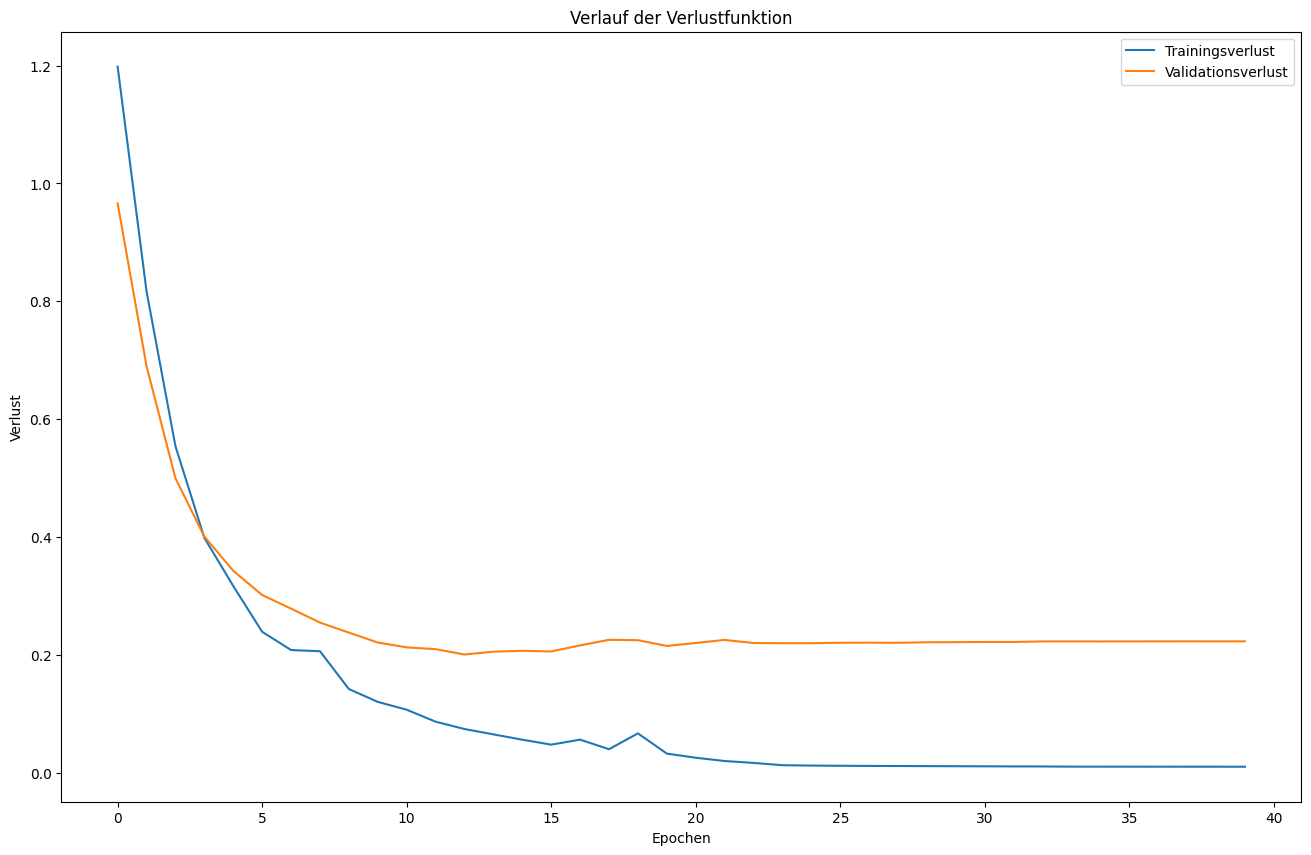

In [22]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['loss'], label="Trainingsverlust")
plt.plot(range(epochs), history.history['val_loss'], label="Validationsverlust")

plt.xlabel("Epochen")
plt.ylabel("Verlust")
plt.legend()
plt.title("Verlauf der Verlustfunktion")

plt.show()

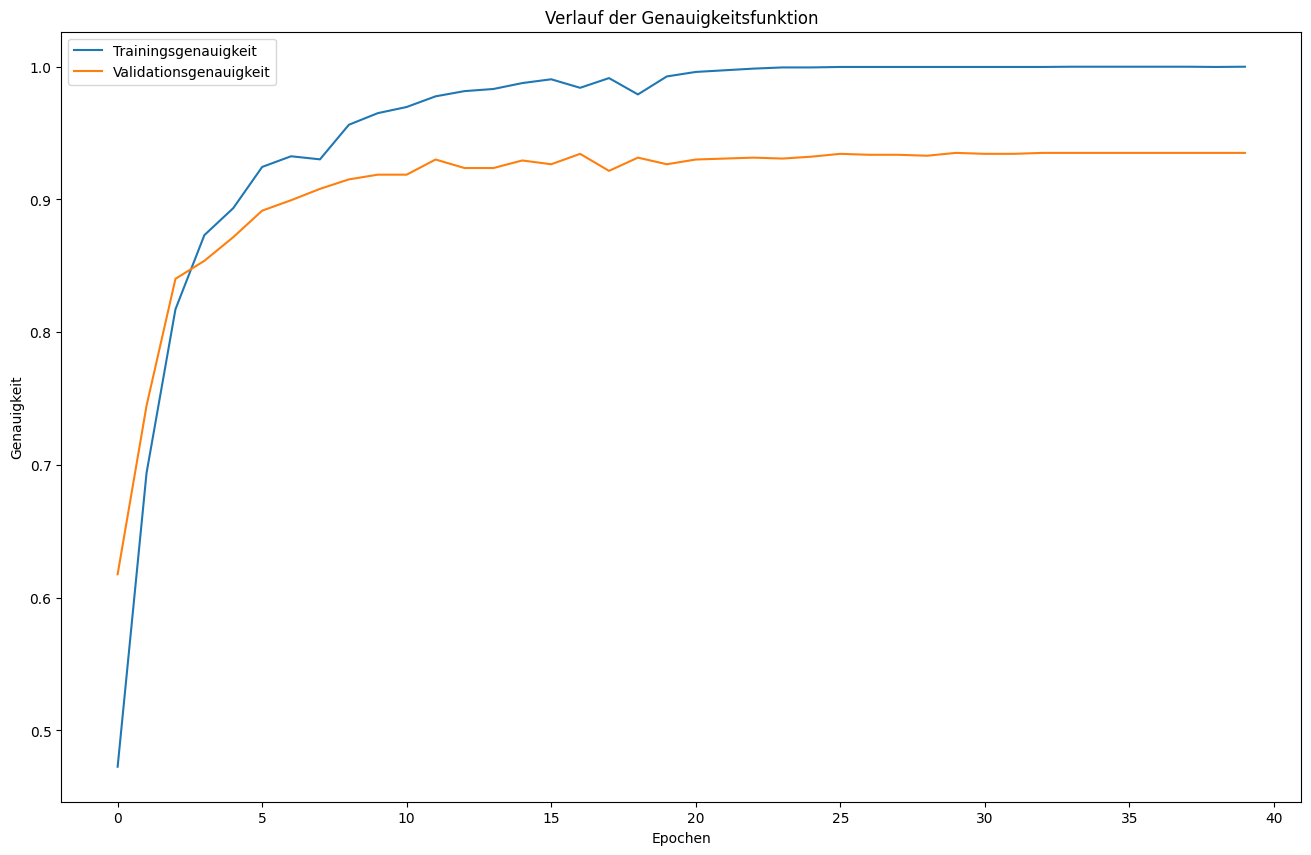

In [23]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['accuracy'], label="Trainingsgenauigkeit")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validationsgenauigkeit")

plt.xlabel("Epochen")
plt.ylabel("Genauigkeit")
plt.legend()
plt.title("Verlauf der Genauigkeitsfunktion")

plt.show()

### ▶️ Modell auf Testdaten anwenden und evaluieren

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2624538838863373
Test accuracy: 0.9235873222351074


In [25]:
y = model.predict(np.array(X))[6000]
print(X[2390])
print(np.argmax(y))


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[-0.56445484  2.18647108  0.14812063 -0.43946984  0.06493704 -0.01724671
  0.88774921  0.2376549   1.30584623 -0.45147283  1.34301717 -0.03712412
  1.27453609  0.2759113  -0.50509277 -0.40078092 -1.33159074  1.56378647
  1.74820899 -1.93040628 -1.16900804 -0.14795379  0.53149797  0.4401094
 -0.24836754 -4.70579721 -3.68246993 -1.00072481  0.33670863  0.51365117
 -1.83756334 -1.0454651  -0.23077258 -0.76029157  1.94939006  1.18021955
 -0.55548398 -1.54855048 -1.81684488 -0.33746241 -0.61449041  0.5630555
 -2.25535513 -0.04807494  0.56171558  0.28687285  3.07570541 -0.34307822
  0.63803381 -1.18582991 -0.24402482  0.50554743 -0.3334728  -0.29436544
 -0.96384731  0.25944087 -0.28362617 -0.10490703 -0.85144408 -0.3107567
  0.90504701 -0.53327589 -1.64500821 -0.92668625]
2


### ▶️ Metriken zur Beurteilung der Modellqualität 

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


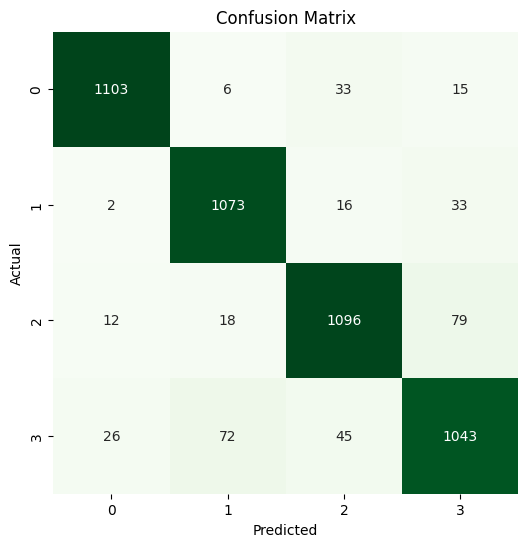

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1157
           1       0.92      0.95      0.94      1124
           2       0.92      0.91      0.92      1205
           3       0.89      0.88      0.89      1186

    accuracy                           0.92      4672
   macro avg       0.92      0.92      0.92      4672
weighted avg       0.92      0.92      0.92      4672



In [26]:
y_true = np.array(y_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred))